In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

In [3]:
from mmctools.coupling.sowfa import InternalCoupling
from mmctools.plotting import plot_timehistory_at_height, plot_profile
from mmctools.helper_functions import covariance

# Read WRF data and convert to SOWFA input files
## FINO1 internal coupling case

Regis Thedin\
regis.thedin@nrel.gov

In [4]:
# Define some constants
g  = 9.81            # Gravity [m s-2]
T0 = 300             # Reference temperature for perturbation temperature [K]
K  = 0.41            # von Karman constant
R_air = 287.058      # Specific gas constant for dry air [J kg-1 K-1]
Cp_air = 1005        # Specific heat of air [J kg-1 K-1]
P0 = 100000          # Reference pressure [Pa]
kappa = R_air/Cp_air # Poisson constant

## 1. Load dataset

In [5]:
# Open dataset. This needs to be updated with your own mesoscale run results
ds = xr.open_dataset('/projects/mmc/phawbeck/FINO1_d03_full.nc')

In [6]:
# Entire dataset sent spans 2010-05-14 12:00:03 to 2010-05-17 00:00:00, 3-sec temporal resolution
dateref = '2010-05-14 12:00:03'
datefrom = '2010-05-14 12:00:03'
dateto = '2010-05-17 00:00:00'

In [7]:
df = ds.to_dataframe()
df = df.reset_index()
df.set_index(['datetime', 'height'], inplace=True)

### Description of the variables
from https://github.com/a2e-mmc/mmctools/blob/master/mmctools/wrf/utils.py

    'dom',    # grid ID     
    'time',   # forecast time in hours
    'tsID',   # time series ID
    'locx',   # grid location x (nearest grid to the station)
    'locy',   # grid location y (nearest grid to the station)
    'T2',     # 2 m Temperature [K]
    'q2',     # 2 m vapor mixing ratio [kg/kg]
    'u10',    # 10 m U wind (earth-relative)
    'v10',    # 10 m V wind (earth-relative)
    'PSFC',   # surface pressure [Pa]
    'LWd',    # downward longwave radiation flux at the ground (downward is positive) [W/m^2]
    'SWd',    # net shortwave radiation flux at the ground (downward is positive) [W/m^2]
    'HFX',    # surface sensible heat flux (upward is positive) [W/m^2]
    'LFX',    # surface latent heat flux (upward is positive) [W/m^2]
    'TSK',    # skin temperature [K]
    'SLTtop', # top soil layer temperature [K]
    'RAINC',  # rainfall from a cumulus scheme [mm]
    'RAINNC', # rainfall from an explicit scheme [mm]
    'CLW',    # total column-integrated water vapor and cloud variables

In [8]:
# Get unique heights
h = df.index.unique(level='height')

### 1.1 Compute additional parameters

In [9]:
# density, in kg/m^3
df['rho'] = df['psfc'] / (R_air*df['t2'])

# Kinematic heat flux, in K-m/s
df['wt']  = df['hfx'] / (Cp_air*df['rho'])

In [10]:
# Friction velocity, in m/s
uw = covariance(df['u'], df['w'])
vw = covariance(df['v'], df['w'])
df['ustar'] = (uw**2 + vw**2)**(1/4)

# Obukhov length, in m
df['L0']  = -df['ustar']**3 * df['t2'] / (K * g * df['wt'])

In [11]:
# Surface skin potential temperature, in Kelvin
df['thetask'] = df['tsk'] * (P0/df['psfc'])**kappa

# Potential temperature at 2 m, in Kelvin
df['theta2'] = df['t2'] * (P0/df['psfc'])**kappa

### 1.2 Load surface roughness information
Pat sent a file containing the time history of the surface roughness.

In [12]:
z0 = pd.read_csv('FINO1_z0_PeriodOfInterest.txt', sep='\t')

In [13]:
z0['datetime'] = pd.to_datetime(z0['YYYYMMDDHHmmSS'], format='%Y%m%d%H%M%S')
z0 = z0.drop('YYYYMMDDHHmmSS',1)
z0 = z0.set_index('datetime')

/tmp/ipykernel_179682/2308591970.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  z0 = z0.drop('YYYYMMDDHHmmSS',1)


In [14]:
# Save dataframe
df.reset_index().to_feather('FINO1_d03_full.ftr')

In [15]:
df = pd.read_feather('FINO1_d03_full.ftr')

In [16]:
df

,datetime,height,nz,station,qv,theta,v,u,pr,w,...,rainnc,clw,wspd,wdir,rho,wt,ustar,L0,thetask,theta2
0,2010-05-14 12:00:03,2.430962,0,FN1,0.004580,279.698898,-1.322026,1.014161,101377.170166,-4.289365e-07,...,0.0,0.00268,1.666216,322.507226,1.257679,0.005976,0.000000,-0.000000,280.644328,279.719803
1,2010-05-14 12:00:03,7.255672,1,FN1,0.004580,279.695797,-1.326994,1.021679,101317.874952,-2.011639e-04,...,0.0,0.00268,1.674736,322.406620,1.257679,0.005976,0.000000,-0.000000,280.644328,279.719803
2,2010-05-14 12:00:03,12.081451,2,FN1,0.004575,279.694255,-1.329929,1.027632,101258.541648,-4.171770e-04,...,0.0,0.00268,1.680696,322.306856,1.257679,0.005976,0.000000,-0.000000,280.644328,279.719803
3,2010-05-14 12:00:03,16.908794,3,FN1,0.004570,279.694368,-1.330790,1.032324,101199.232054,-6.428463e-04,...,0.0,0.00268,1.684249,322.198461,1.257679,0.005976,0.000000,-0.000000,280.644328,279.719803
4,2010-05-14 12:00:03,21.737381,4,FN1,0.004570,279.694770,-1.331602,1.037943,101140.441536,-8.770825e-04,...,0.0,0.00268,1.688339,322.064686,1.257679,0.005976,0.000000,-0.000000,280.644328,279.719803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263995,2010-05-17 00:00:00,13045.626953,82,FN1,0.000000,368.099846,9.593041,2.551742,17266.413227,3.025991e-03,...,0.0,0.00083,9.926622,194.895712,1.250885,0.000730,0.002377,-0.001288,281.009140,280.837227
6263996,2010-05-17 00:00:00,13759.878906,83,FN1,0.000000,380.175029,5.765159,2.800145,15466.556622,5.479789e-03,...,0.0,0.00083,6.409202,205.905904,1.250885,0.000730,0.005221,-0.013649,281.009140,280.837227
6263997,2010-05-17 00:00:00,14465.685547,84,FN1,0.000000,392.243737,3.547810,1.870793,13872.477475,1.480235e-03,...,0.0,0.00083,4.010838,207.803095,1.250885,0.000730,0.007148,-0.035020,281.009140,280.837227
6263998,2010-05-17 00:00:00,15162.194336,85,FN1,0.000000,404.982302,2.724980,1.863172,12460.711015,-9.256627e-04,...,0.0,0.00083,3.301050,214.361891,1.250885,0.000730,0.001174,-0.000155,281.009140,280.837227


In [17]:
df['Leq'] = - (df['ustar']**3 * df['thetask'])/(K*g*df['wt'])

NameError: name 'LESfrom' is not defined

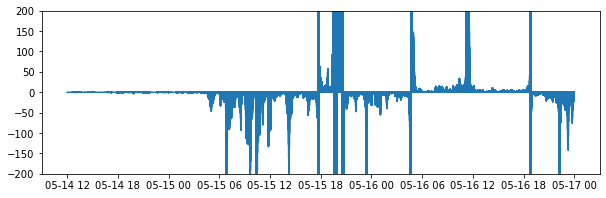

In [18]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(df['datetime'],df['L0'])

ax.set_ylim([-200,200])
ax.set_xlim([pd.to_datetime(LESfrom), pd.to_datetime(LESto) ])

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(df['datetime'],df['Leq'])

ax.set_ylim([-200,200])
ax.set_xlim([pd.to_datetime(LESfrom), pd.to_datetime(LESto) ])

## 2. Write SOWFA-ready input files

In [14]:
# directory for SOWFA-ready output data
dirout = 'drivingData/'

### 2.1 Microscale inputs

In [15]:
# LES 4-hour period interest
LESfrom='2010-05-16 01:00:03'
LESto='2010-05-16 05:00:03'

In [16]:
# Average surface roughness on the period of interest for input to SOWFA
print('The input value of z0 is', z0.loc[LESfrom:LESto].mean())

The input value of z0 is z0    0.000382
dtype: float64


In [17]:
# Average of temperature gradient at the top of SOWFA domain
# Computed using simple finite differences using two measurements
zmax = 1500
hbelow = np.abs(h - zmax).argmin()
habove = np.abs(h - zmax).argmin() + 1

thetadiff = df.xs(h[habove],level='height')['theta'] - df.xs(h[hbelow],level='height')['theta']
gradT = thetadiff/(h[habove]-h[hbelow])

print('The input value of grad(theta) at the upper patch is', gradT.loc[LESfrom:LESto].mean())

The input value of grad(theta) at the upper patch is 0.005884325795736251


### Start and end times

In [18]:
# Times in seconds to input to sowfa
tdelta_from = pd.to_datetime(LESfrom) - pd.to_datetime(datefrom)
tdelta_to = pd.to_datetime(LESto) - pd.to_datetime(datefrom)
tdelta_spinup = pd.Timedelta(seconds=20000)

In [19]:
# Spin-up start time (only used for plotting)
LESspinupfrom = pd.to_datetime(LESfrom) - pd.Timedelta(seconds=20000)

In [20]:
SOWFA_LESspinupfrom = (tdelta_from - tdelta_spinup)/np.timedelta64(1,'s')
SOWFA_LESfrom = tdelta_from/np.timedelta64(1,'s')
SOWFA_LESto = tdelta_to/np.timedelta64(1,'s')

In [21]:
print('The microscale sim will start at', SOWFA_LESspinupfrom, 's.')
print('After 20,000 s of spin-up time, at', SOWFA_LESfrom, 's, the 4-hour window of interest will start.')
print('The sim will end at instant', SOWFA_LESto, 's.')

The microscale sim will start at 113200.0 s.
After 20,000 s of spin-up time, at 133200.0 s, the 4-hour window of interest will start.
The sim will end at instant 147600.0 s.


The data saved as BC and IC will be in this reference time, since 0 seconds in SOWFA refers to the `dateref` defined earlier.



### 2.2. Write forcing and IC tables
Forcing table `fieldTable` goes into `ABLProperties` and initial conditions table `initialValues` into `setFieldsABLDict`.

In [22]:
# construct the object with the information
to_sowfa = InternalCoupling(dirout,df,dateref,datefrom,dateto)

In [23]:
# write time-height data
to_sowfa.write_timeheight('fieldTable',xmom='u',ymom='v',zmom='w',temp='theta')
# write initial conditions
to_sowfa.write_ICs('initialValues',xmom='u',ymom='v',temp='theta')

### 2.3. Write BC
Write BC table `surfaceSkinPotentialTemperatureTable`  for `qwall`.

In [24]:
# Generate dataframe with surface parameters
df_bc = df.loc[:,['tsk','t2','thetask','theta2','wt']].reset_index()
df_bc.set_index('datetime',inplace=True)
df_bc = df_bc.loc[df_bc.height==h[0]].copy()

In [25]:
# construct BC object
to_sowfabc = InternalCoupling(dirout,df_bc,dateref,datefrom,dateto)

In [26]:
# write BCs
to_sowfabc.write_BCs('surfaceSkinTemperatureTable',fieldname='tsk')
to_sowfabc.write_BCs('surface2mTemperatureTable',fieldname='t2')
to_sowfabc.write_BCs('surfaceSkinPotentialTemperatureTable',fieldname='thetask')
to_sowfabc.write_BCs('surface2mPotentialTemperatureTable',fieldname='theta2')
to_sowfabc.write_BCs('surfaceTemperatureFluxTable',fieldname='wt',fact=-1.0)

## 3. Visualize the data and perform some sanity checks


### 3.1. Check input surface roughness

Text(0, 0.5, 'z0 (m)')

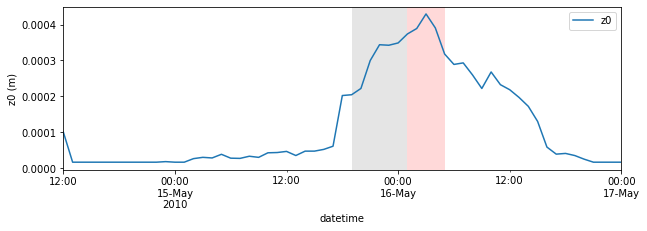

In [27]:
# Plot surface roughness 
ax = z0.plot(figsize=(10,3))
ax.axvspan(LESspinupfrom, LESfrom, facecolor='black', alpha=0.1)
ax.axvspan(LESfrom, LESto, facecolor='red', alpha=0.15)
ax.set_ylabel('z0 (m)')

(353881.0, 353885.0)

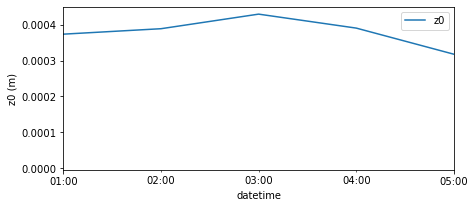

In [28]:
# zoom over the period of interest
ax = z0.plot(figsize=(7,3))
ax.set_ylabel('z0 (m)')
ax.set_xlim([LESfrom, LESto])

### 3.2. Check temperature gradient at top of SOWFA domain

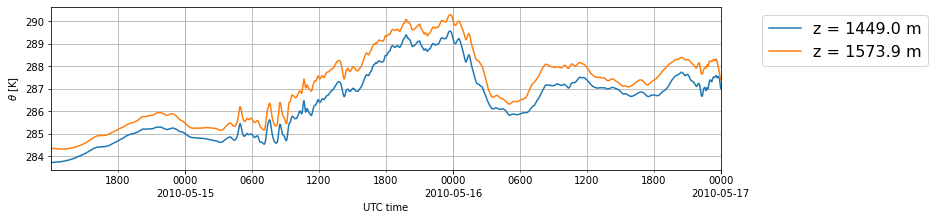

In [29]:
# See the potential temperature gradient at the top of SOWFA domain (for input to T.upper BC)
fig,ax = plot_timehistory_at_height(
    df,
    fields=['theta'],
    heights=h[hbelow:habove+1],
    timelimits=[datefrom, dateto],
    fieldlabels={'theta':r'$\theta$ [K]'},
    showlegend=True,
    plot_local_time=False,
    #local_time_offset=-6
)

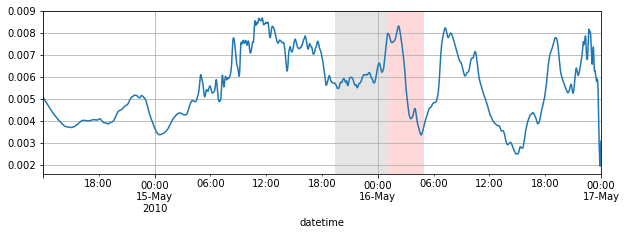

In [30]:
ax = gradT.plot(figsize=(10,3))
ax.axvspan(LESspinupfrom, LESfrom, facecolor='black', alpha=0.1)
ax.axvspan(LESfrom, LESto, facecolor='red', alpha=0.15)
ax.grid()

In [31]:
gradT.loc[LESfrom:LESto].mean()

0.005884325795736251

### 3.3. Check values of computed quantities

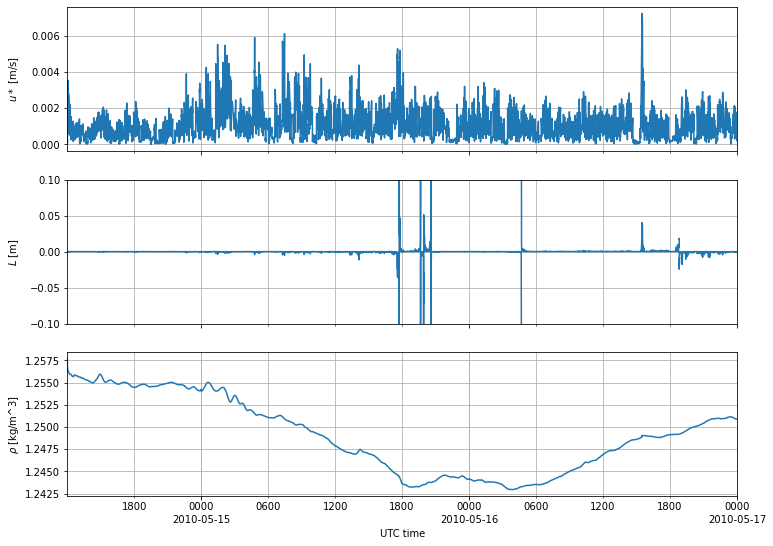

In [32]:
# Check values of ustar, L, rho
fig,ax = plot_timehistory_at_height(
    df,
    fields=['ustar','L0','rho'],
    heights=h[0],
    timelimits=[datefrom, dateto],
    fieldlabels={'ustar':r'$u*$ [m/s]','L0':r'$L$ [m]','rho':r'$\rho$ [kg/m^3]'},
    fieldlimits={'L0':(-0.1,0.1)},
    showlegend=False,
    plot_local_time=False,
    #local_time_offset=-6
)

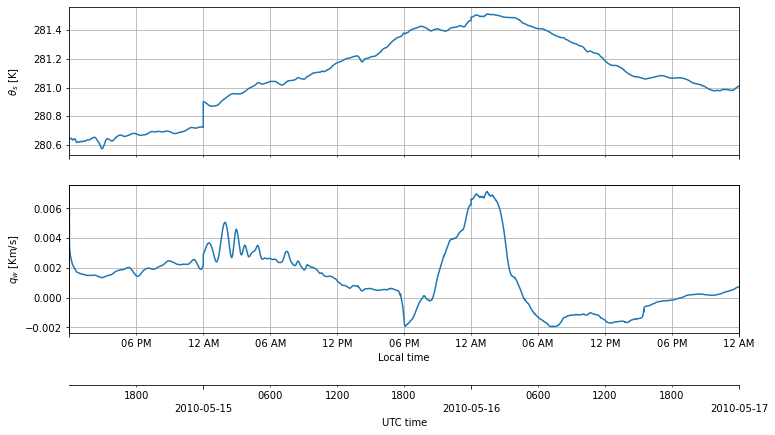

In [33]:
fig,ax,ax2 = plot_timehistory_at_height(
    df_bc,
    fields=['thetask','wt'],
    heights=h[0],
    timelimits=[datefrom, dateto],
    fieldlabels={'thetask':r'$\theta_s$ [K]','wt':r'$q_w$ [Km/s]'},
    showlegend=False,
    plot_local_time=True,
    #local_time_offset=-6
)

### 3.4. Check time histories of entire dataset

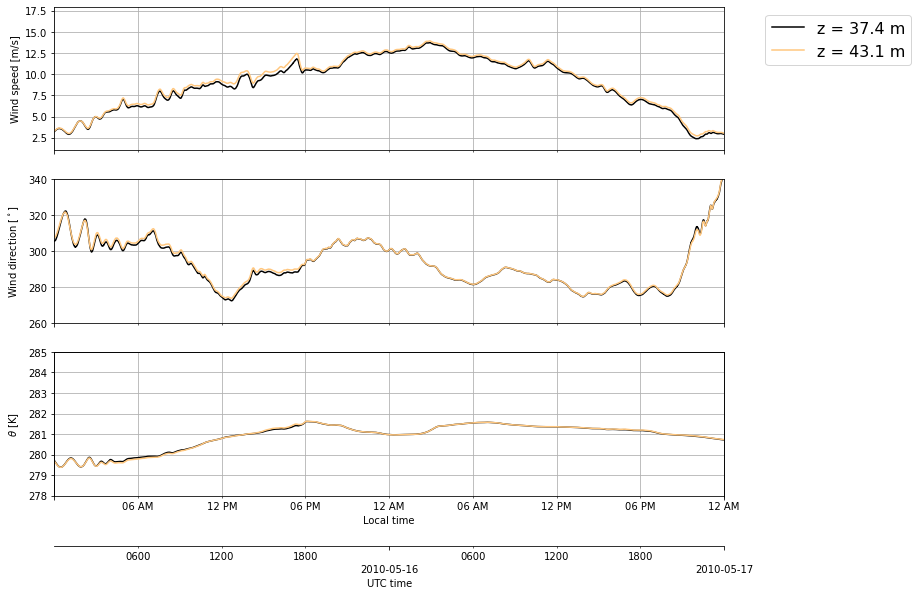

In [34]:
# plot data at around 40m to compare to Pat's plots
fig,ax,ax2 = plot_timehistory_at_height(
    df,
    fields=['wspd','wdir','theta'],
    heights=h[7:9],
    cmap='copper',
    timelimits=['2010-05-15 00:00:03',dateto],
    fieldlimits={'wspd':(1,18),'wdir':(260,340),'theta':(278,285)},
    plot_local_time=True
)

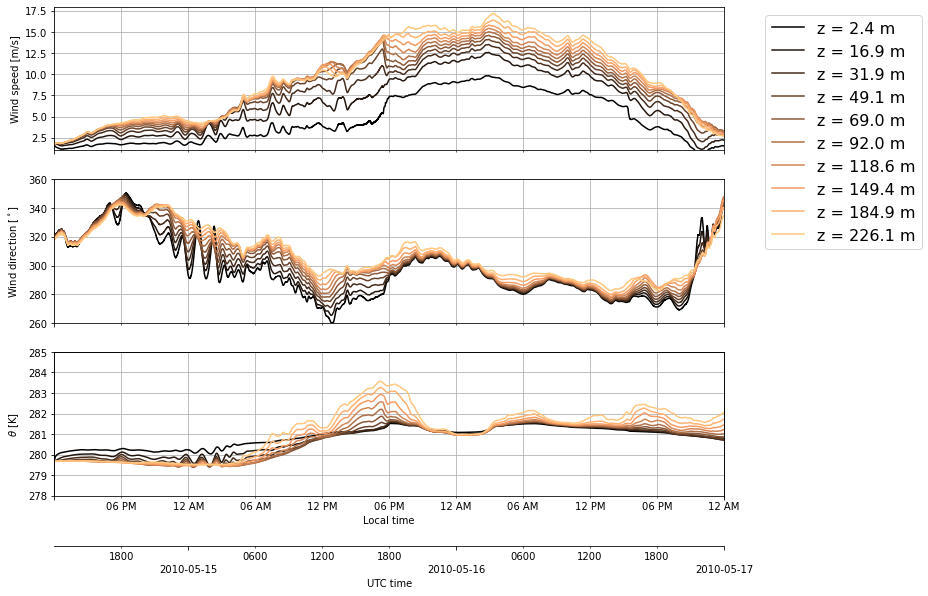

In [35]:
# See evolution of profiles up arouns 250m
fig,ax,ax2 = plot_timehistory_at_height(
    df,
    fields=['wspd','wdir','theta'],
    heights=h[0:30:3],
    cmap='copper',
    timelimits=[datefrom,dateto],
    fieldlimits={'wspd':(1,18),'wdir':(260,360),'theta':(278,285)},
    plot_local_time=True
)